In [1]:
import pickle
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sksurv.preprocessing import OneHotEncoder as SurvOneHotEncoder
from sksurv.util import Surv

from sksurv.column import encode_categorical
from sksurv.column import standardize
from sklearn.model_selection import train_test_split

from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
    brier_score
)

pd.set_option('display.max_rows', 500)

In [2]:
# pickle_file = 'data/COX_DATA_FULL_DECEASED_EXPERIMENTAL.pkl'
# pickle_file = 'data/DATA_DECEASED.pkl'
pickle_file = 'data/DATA_DECEASED_ex.pkl'

with open(pickle_file, 'rb') as f:
    dataset = pickle.load(f)

In [3]:
dataset.to_csv('data/DATA_DECEASED_ex.csv', index=False)

In [4]:
numeric_features = [
    "AGE",
    "BMI_CALC",
    "AGE_DON",
    "CREAT_TRR",
    "NPKID",
    "COLD_ISCH_KI",
    "DIALYSIS_TIME",
    "KDPI",
]
categorical_features = [
    "ON_DIALYSIS",
    "PRE_TX_TXFUS",
    "GENDER",
    "ETHCAT",
    "DIABETES_DON",
    "DIAB",
    "HCV_SEROSTATUS",
]


In [5]:

def preprocess_data(feature_importance):
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ])
    preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_features),
                ('cat', categorical_transformer, categorical_features)
            ]
        )

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor)
    ])

    if feature_importance:
        categorical_x = encode_categorical(dataset[categorical_features])
        numerical_x = standardize(dataset[numeric_features])
        X = pd.concat([numerical_x, categorical_x], axis=1)
    else:
        X = pipeline.fit_transform(dataset[categorical_features + numeric_features])
    
    survival_time = dataset["PTIME"].astype(np.float64)
    event = dataset["PSTATUS"].astype(float).astype(bool)
    y = Surv.from_arrays(event, survival_time, "Status", "Days")

    return X, y


X, y = preprocess_data(True)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y["Status"], random_state=42)

In [7]:
X_train.head()

,AGE,BMI_CALC,AGE_DON,CREAT_TRR,NPKID,COLD_ISCH_KI,DIALYSIS_TIME,KDPI,ON_DIALYSIS=Y,PRE_TX_TXFUS=Y,...,ETHCAT=6,ETHCAT=7,DIABETES_DON=Y,DIAB=2.0,DIAB=3.0,DIAB=4.0,DIAB=5.0,DIAB=998.0,HCV_SEROSTATUS=ND,HCV_SEROSTATUS=P
__null_dask_index__,,,,,,,,,,,,,,,,,,,,,
168,1.456985,-0.751101,1.201540,-0.575300,-0.337364,1.384782,-0.913116,1.383906,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
310,-0.451411,-1.101481,-0.848389,-1.114998,2.435534,-1.609925,-0.715460,-1.396717,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
238,-0.298739,-1.470303,0.417744,1.583495,2.435534,3.226055,0.234130,0.197507,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
497,0.922634,-0.751101,-0.908681,-1.299632,-0.337364,0.486926,0.091986,-0.581068,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
308,-0.146067,1.185214,1.020664,1.753926,-0.337364,0.925853,-0.082119,1.569281,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [8]:
def evaluate_model_uno_c(model, test_X, test_y, train_y, times):
    pred = model.predict(test_X)
    uno_concordance = concordance_index_ipcw(train_y, test_y, pred, tau=times[-1])
    return uno_concordance

def evaluate_model(model, test_X, test_y, train_y, times):
    pred = model.predict(test_X)
    surv_fn = model.predict_survival_function(test_X, return_array=False)
    surv_prob = np.row_stack([fn(times) for fn in surv_fn])

    uno_concordance = concordance_index_ipcw(train_y, test_y, pred, tau=times[-1])
    ibs = integrated_brier_score(train_y, test_y, surv_prob, times)
    auc, mean_auc = cumulative_dynamic_auc(train_y, test_y, pred, times)

    print(f"Concordance Uno: {round(uno_concordance[0], 3)}")
    print(f"IBS: {round(ibs, 3)}")
    print(f"Mean AUC: {round(mean_auc,3)}")

    return uno_concordance, ibs, mean_auc

In [9]:
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sklearn.model_selection import KFold, GridSearchCV

lower, upper = np.percentile(y["Days"], [10, 90])
times = np.arange(lower, upper + 1)

cox = CoxnetSurvivalAnalysis(l1_ratio=0.9, max_iter=1000)
cox.fit(X_train, y_train)

estimated_alphas = cox.alphas_

cv = KFold(n_splits=5, shuffle=True, random_state=0)
gcv = GridSearchCV(
    CoxnetSurvivalAnalysis(l1_ratio=0.9),
    param_grid={"alphas": [[v] for v in estimated_alphas]},
    cv=cv,
    error_score=0.5,
    n_jobs=-1,
).fit(X_train, y_train)

cv_results = pd.DataFrame(gcv.cv_results_)

/Users/kyrylo/anaconda3/envs/kidney-life/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:729: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
/Users/kyrylo/anaconda3/envs/kidney-life/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:729: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)


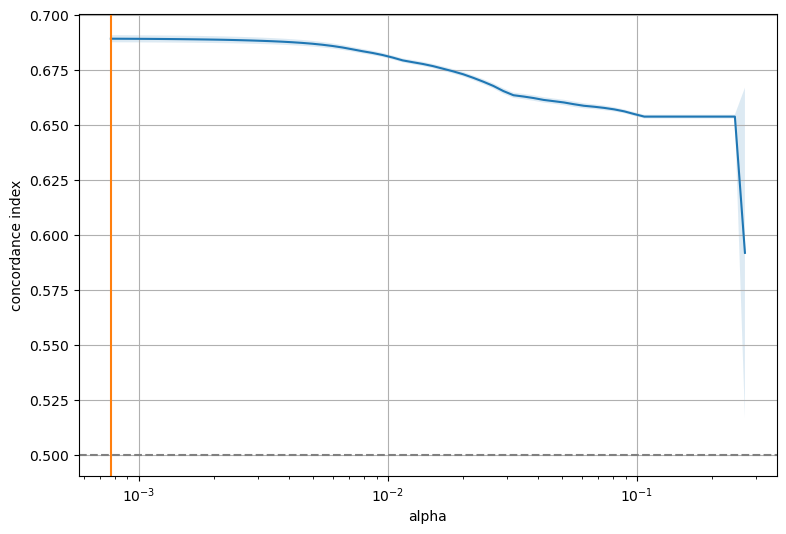

In [10]:
import matplotlib.pyplot as plt

alphas = cv_results.param_alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=0.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(gcv.best_params_["alphas"][0], c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)

In [11]:
print("Best alpha:", gcv.best_params_["alphas"][0])

Best alpha: 0.0007723690059622161


In [12]:
best_params = gcv.best_params_

coxnet_pred = CoxnetSurvivalAnalysis(l1_ratio=0.9, alphas=[best_params['alphas'][0]], fit_baseline_model=True)
coxnet_pred.fit(X_train, y_train)
_,_,_ = evaluate_model(coxnet_pred, X_test, y_test, y_train, times)

Concordance Uno: 0.695
IBS: 0.163
Mean AUC: 0.73


Number of non-zero coefficients: 19


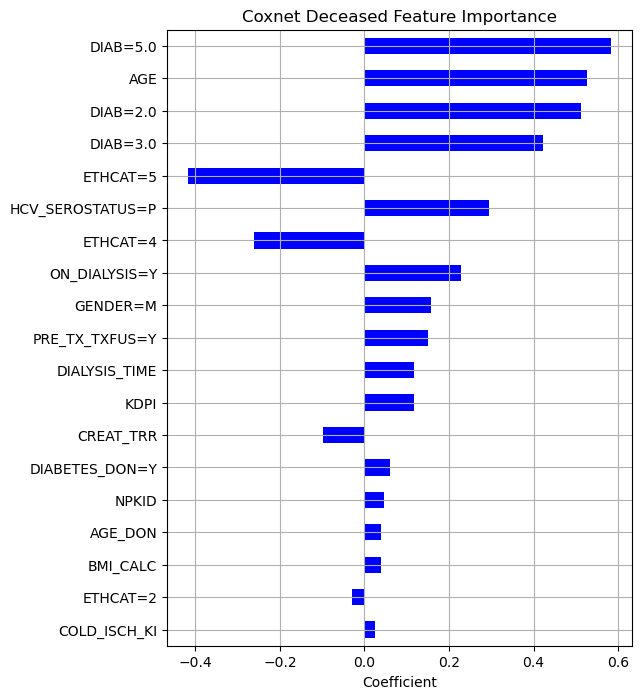

In [13]:
# Visual demonstration of feature importance. Uncomment if features weren't processed with pipeline

best_model = gcv.best_estimator_
best_coefs = pd.DataFrame(best_model.coef_, index=X.columns, columns=["coefficient"])

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print(f"Number of non-zero coefficients: {non_zero}")

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False, color='blue')
ax.set_xlabel("Coefficient")
ax.set_title("Coxnet Deceased Feature Importance")
ax.grid(True)
path = "../Thesis/Images/Results/"
# plt.savefig(path + "Coxnet_FI_deceased.pdf", bbox_inches="tight")
plt.show()

In [14]:
import pickle

# with open('pickle/COXNET_DECEASED_MODEL.pickle', 'wb') as f:
#     pickle.dump(coxnet_pred, f)

In [15]:
from sklearn.inspection import permutation_importance


result = permutation_importance(coxnet_pred, X_test, y_test, n_repeats=10, random_state=0, n_jobs=1)

In [16]:
pd.set_option('display.max_rows', 500)

columns = numeric_features + categorical_features

importances_df = pd.DataFrame(result.importances_mean, index=X.columns)
importances_df.columns = ['Importance']
importances_df.sort_values(by='Importance', ascending=False, inplace=True)

# Print out feature importances
importances_df

,Importance
AGE,0.103255
DIAB=5.0,0.016450
DIAB=3.0,0.012151
KDPI,0.005778
CREAT_TRR,0.004614
DIAB=2.0,0.003597
DIALYSIS_TIME,0.003456
ON_DIALYSIS=Y,0.003447
ETHCAT=4,0.003429
ETHCAT=5,0.003250


In [ ]:
import matplotlib.pyplot as plt
plt_importances = importances_df.sort_values(by='Importance', ascending=True)
plt_importances['Importance']=plt_importances['Importance'].astype(float)

In [ ]:
diab = ["DIAB=3.0", "DIAB=5.0", "DIAB=2.0", "DIAB=4.0", "DIAB=998.0"]
eth = ["ETHCAT=2", "ETHCAT=5", "ETHCAT=4", "ETHCAT=6", "ETHCAT=7"] # "ETHCAT=9",
hcv = ["HCV_SEROSTATUS=ND", "HCV_SEROSTATUS=P"]

plt_importances.loc["DIAB", 'Importance'] = plt_importances.loc[diab, 'Importance'].sum()
plt_importances.loc["ETHCAT", 'Importance'] = plt_importances.loc[eth, 'Importance'].sum()
plt_importances.loc["HCV_SEROSTATUS", 'Importance'] = plt_importances.loc[hcv, 'Importance'].sum()

plt_importances.drop(diab, inplace=True)
plt_importances.drop(eth, inplace=True)
plt_importances.drop(hcv, inplace=True)

plt_importances.sort_values(by='Importance', ascending=True, inplace=True)

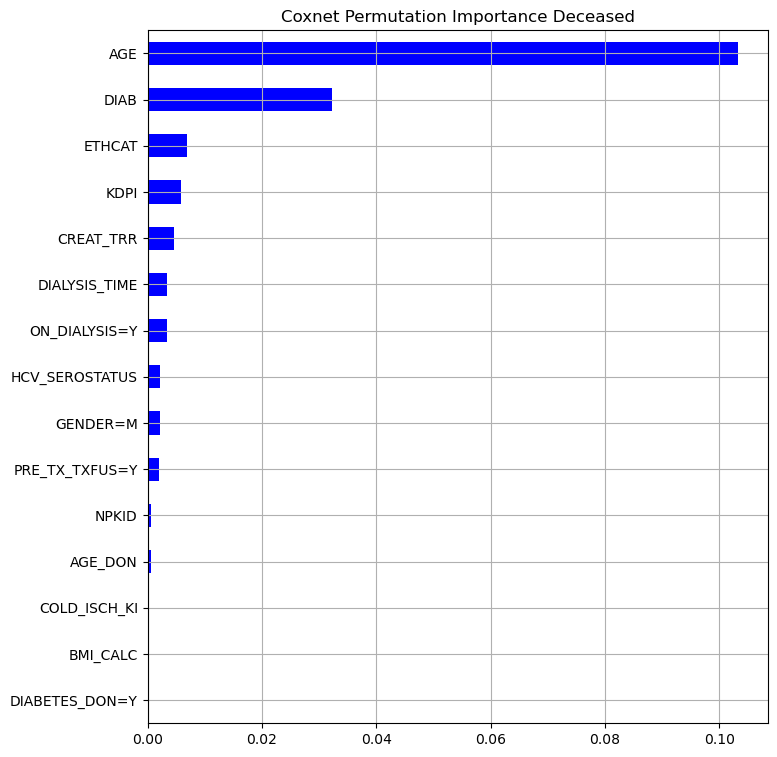

In [24]:
plt_importances.plot.barh(color='blue', legend=False, title='Coxnet Permutation Importance Deceased', grid=True, figsize=(8, 9))
path = "../Thesis/Images/Results/"
plt.savefig(path + "Coxnet_FI_deceased.pdf", bbox_inches="tight")